# Hepatitis C Virus Classification

Dataset: https://archive.ics.uci.edu/dataset/571/hcv+data

## Libraries import

In [453]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import cross_val_predict
import seaborn as sn
from sklearn.metrics import roc_curve, auc

def myPlotROCcurve(target_test, prediction, text=""):
    fpr, tpr, _ = roc_curve(target_test, prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - ' + text)
    plt.legend(loc='lower right')
    plt.show()

def myPlotConfusionMatrix(target_test, prediction, text=""):
    conf_matrix = confusion_matrix(target_test, prediction)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(text)
    plt.show()


def myCrossValidation(classifier, cv_techique, features, target, text=""):
    accuracy = cross_val_score(
    classifier, # Classifier
    features, # Feature matrix
    target, # Target vector
    cv=cv_techique, # Cross-validation technique
    scoring="accuracy", # Loss function
    n_jobs=-1) # Use all CPU scores

    accuracy = np.mean(accuracy)

    precision = cross_val_score(
        classifier, # Classifier
        features, # Feature matrix
        target, # Target vector
        cv=cv_techique, # Cross-validation technique
        scoring="precision", # Loss function
        n_jobs=-1) # Use all CPU scores

    precision = np.mean(precision)

    recall = cross_val_score(
        classifier, # Classifier
        features, # Feature matrix
        target, # Target vector
        cv=cv_techique, # Cross-validation technique
        scoring="recall", # Loss function
        n_jobs=-1) # Use all CPU scores

    recall = np.mean(recall)

    f1 = cross_val_score(
        classifier, # Classifier
        features, # Feature matrix
        target, # Target vector
        cv=cv_techique, # Cross-validation technique
        scoring="f1", # Loss function
        n_jobs=-1) # Use all CPU scores

    f1 = np.mean(f1)

    predictions = cross_val_predict(
        classifier, 
        features, 
        target, 
        cv=cv_techique, 
        method='predict')
    
    return pd.DataFrame({"Accuracy": accuracy,
                         "Precision": precision,
                         "Recall": recall,
                         "F1": f1,
                         "Model": text},
                         index=[0]), predictions

def myResultFormalizer(report, text=""):

    return pd.DataFrame({"Accuracy": float(report['accuracy']),
                         "Precision": float(report['0']['precision']),
                         "Recall": float(report['0']['recall']),
                         "F1": float(report['0']['f1-score']),
                         "Model": text},
                         index=[0])

## Data import and manipulation

In [454]:
dataframe = pd.read_csv('hcvdat0.csv')

dataframe.drop("Unnamed: 0", axis=1, inplace=True)

dataframe.dropna(inplace=True)


scale_mapper = {
    "0=Blood Donor": 0,
    "0s=suspect Blood Donor": 2,
    "1=Hepatitis": 1,
    "2=Fibrosis": 1,
    "3=Cirrhosis": 1,}

# Deviding blood types in two types
dataframe['Category'] = dataframe['Category'].replace(scale_mapper)

dataframe['Sex'] = dataframe['Sex'].replace({"m":0, "f":1})

# Removal of suspect blood donor becaouse they are not useful for model
dataframe = dataframe[dataframe['Category'] != 2]

# Removal of wrong categorized data
dataframe = dataframe[dataframe['Category'].isin([0, 1])]
dataframe = dataframe[dataframe['Sex'].isin([0, 1])]

# Define the age ranges and labels for each category
age_bins = [0, 18, 30, 40, 50, 60, 70, 120]  # Define the age bins
age_labels = [0, 1, 2, 3, 4, 5, 6]  # Define the labels for each age group

# Categorize ages into age groups
dataframe['Age'] = pd.cut(dataframe['Age'], bins=age_bins, labels=age_labels)

dataframe.head(20)

dataframe.to_csv("wrangled_data.csv")


### Outlier detection

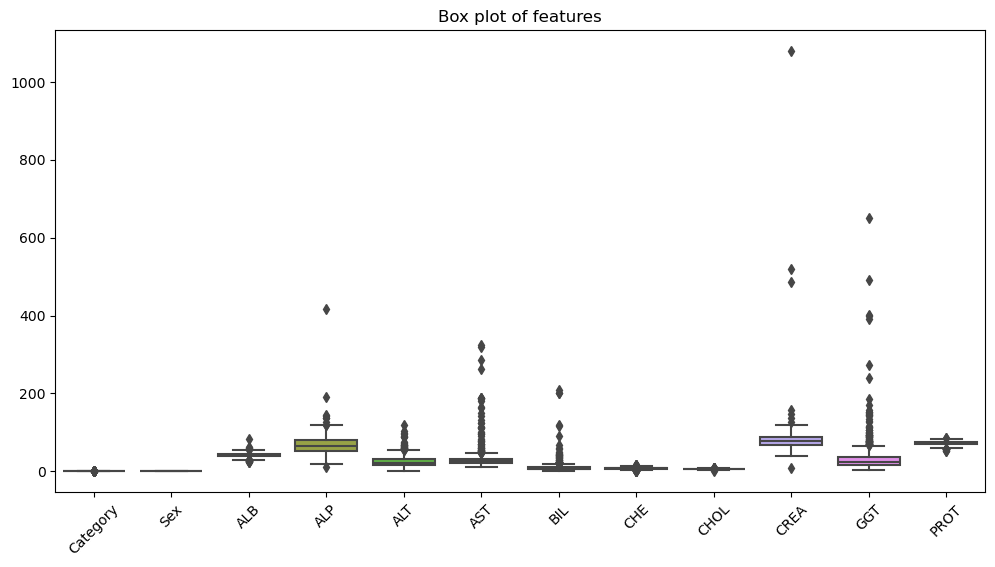

c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

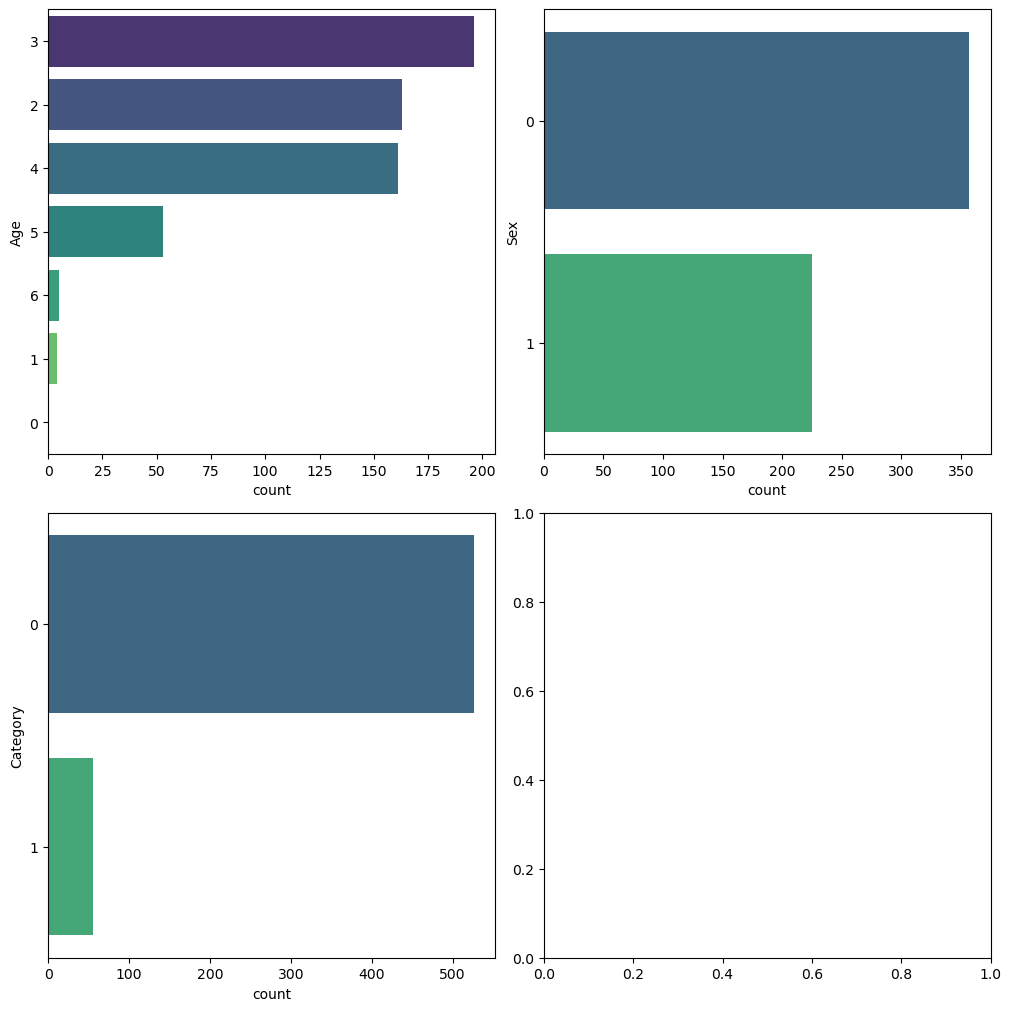

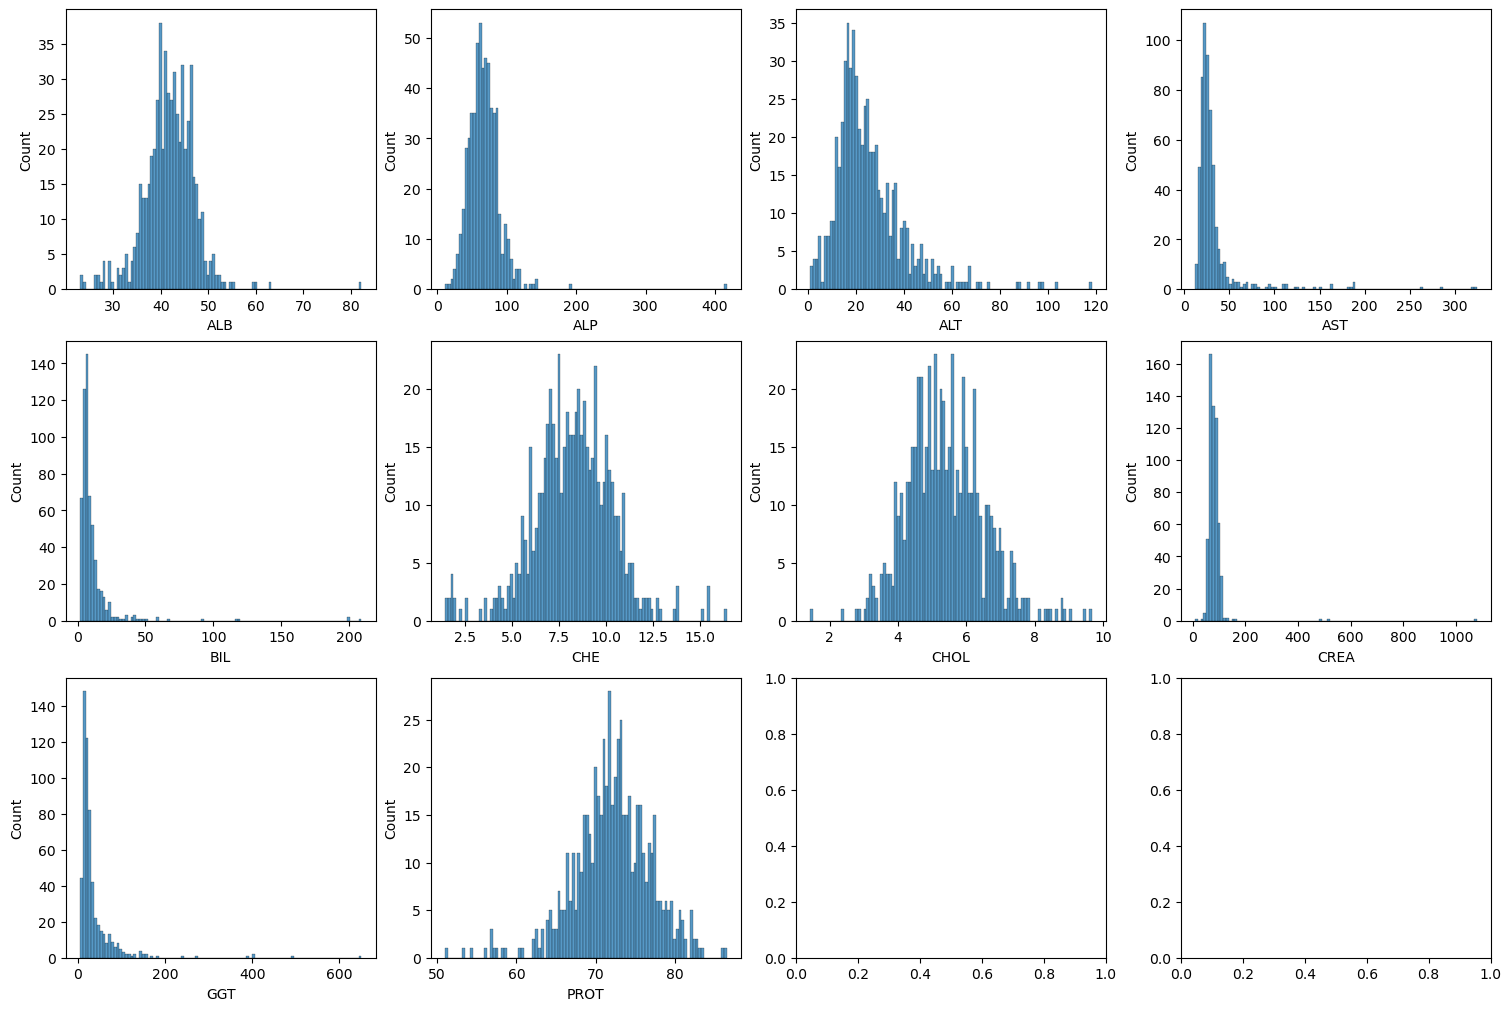

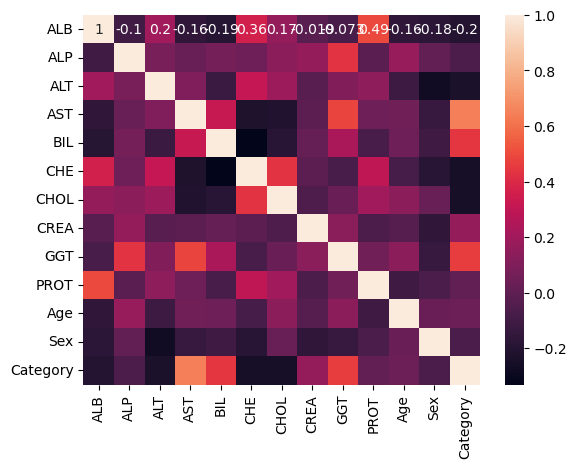

               ALB       ALP       ALT       AST       BIL       CHE  \
ALB       1.000000 -0.103431  0.200235 -0.161389 -0.194822  0.364617   
ALP      -0.103431  1.000000  0.078155  0.027222  0.066974  0.043800   
ALT       0.200235  0.078155  1.000000  0.100191 -0.126918  0.311920   
AST      -0.161389  0.027222  0.100191  1.000000  0.321066 -0.224441   
BIL      -0.194822  0.066974 -0.126918  0.321066  1.000000 -0.330494   
CHE       0.364617  0.043800  0.311920 -0.224441 -0.330494  1.000000   
CHOL      0.167053  0.135502  0.184870 -0.211018 -0.187060  0.428312   
CREA     -0.018850  0.167393 -0.024710 -0.009114  0.019625 -0.013163   
GGT      -0.073379  0.428599  0.102898  0.481591  0.234191 -0.074410   
PROT      0.493732 -0.014861  0.146857  0.048419 -0.071996  0.297580   
Age      -0.159642  0.173311 -0.114250  0.057835  0.048684 -0.085646   
Sex      -0.178748  0.003135 -0.272588 -0.134649 -0.111291 -0.185438   
Category -0.203710 -0.062378 -0.233696  0.645313  0.442584 -0.24

In [455]:
# Create a box plot for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataframe)
plt.title('Box plot of features')
plt.xticks(rotation=45)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)
categorical = ['Age', 'Sex', 'Category']
for i, f in enumerate(categorical):
    sns.countplot(y=f, data=dataframe, ax=axs[i//2][i%2], order=dataframe[f].value_counts().index, palette='viridis')

fig, axs = plt.subplots(3, 4, figsize=(15, 10), constrained_layout=True)
numerical = ['ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
for i, f in enumerate(numerical):
    sns.histplot(x=f, data=dataframe, ax=axs[i//4][i%4], bins=100)  # Adjusted indexing here
plt.show()

corr_matrix = dataframe[[*numerical, *categorical]].corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()
print(corr_matrix)

c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\covariance\_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


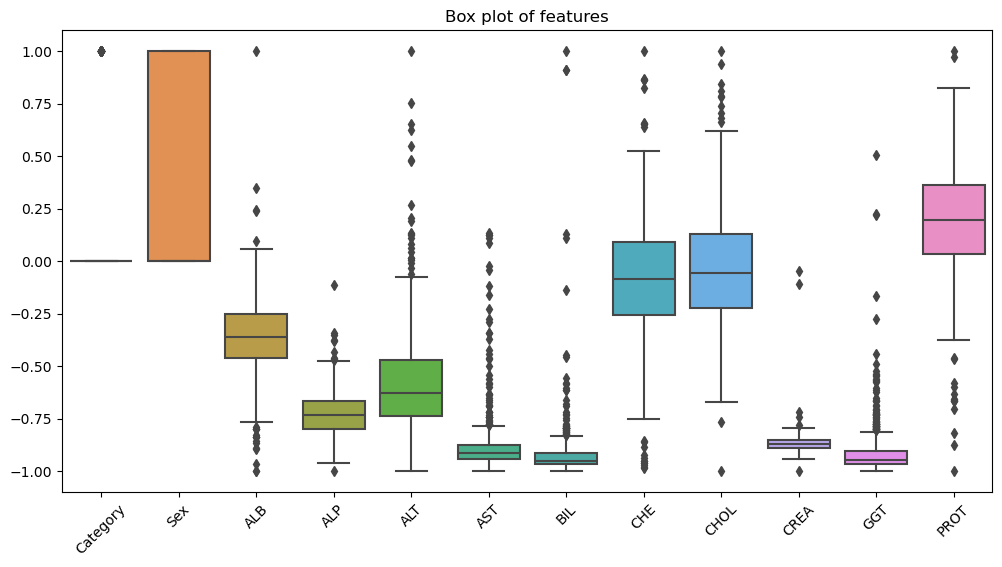

c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

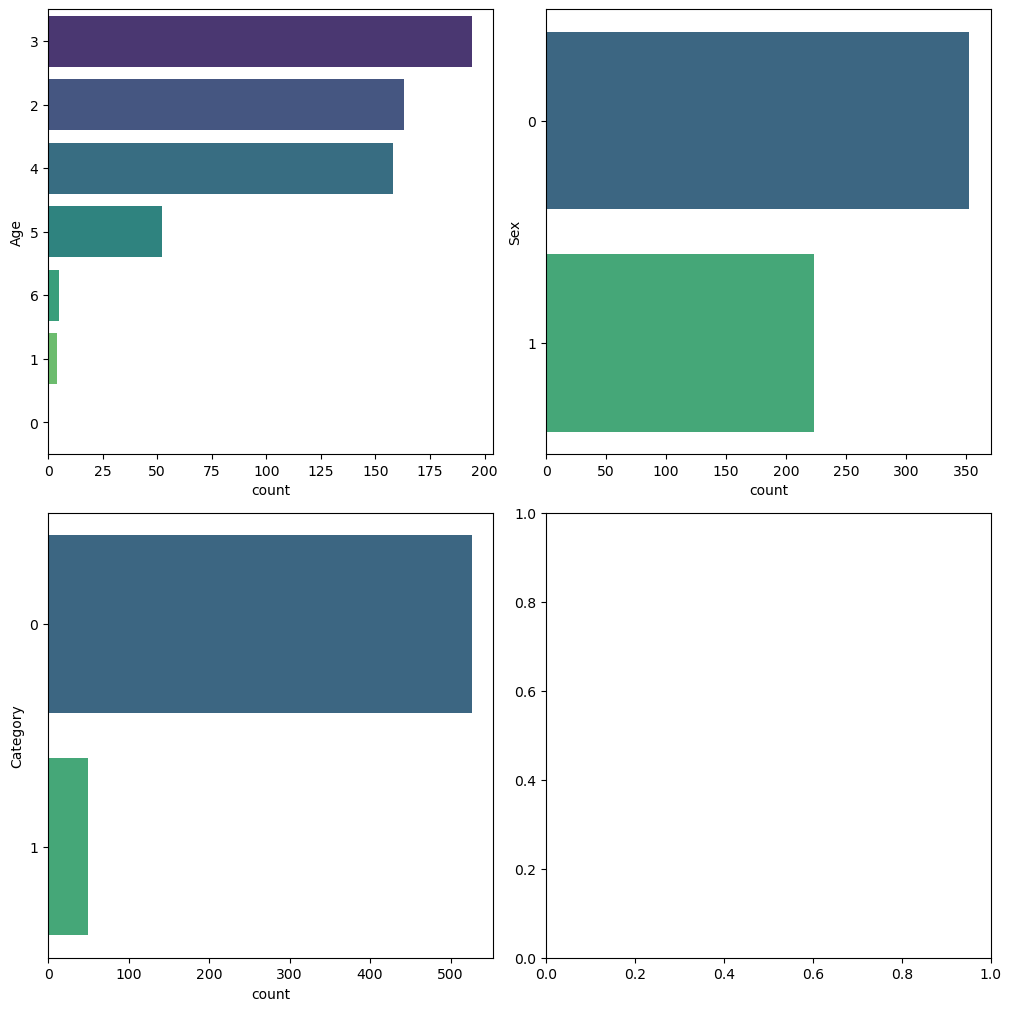

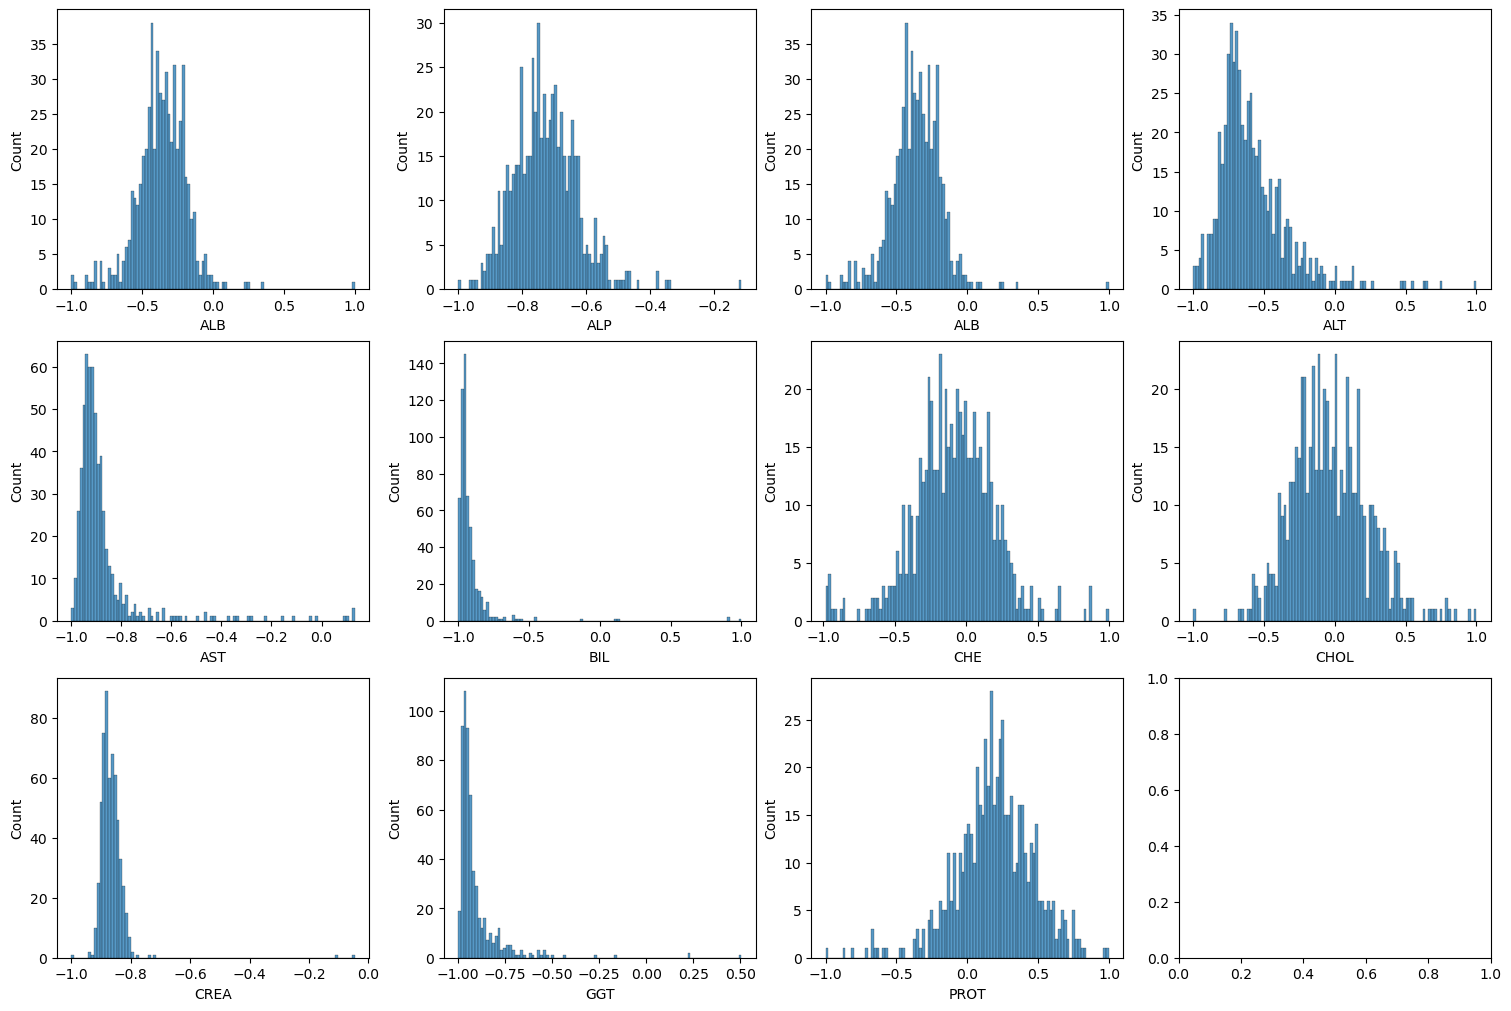

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,2,0,-0.476351,-0.796694,-0.883959,-0.935256,-0.944981,-0.264843,-0.563107,-0.817011,-0.976485,0.014085
1,0,2,0,-0.476351,-0.708858,-0.708191,-0.918590,-0.979730,0.300867,-0.182039,-0.876762,-0.965656,0.436620
2,0,2,0,-0.192568,-0.687145,-0.397611,-0.739744,-0.958494,-0.010007,-0.084951,-0.854355,-0.911200,0.594366
3,0,2,0,-0.317568,-0.799161,-0.493174,-0.932051,-0.834942,-0.211474,-0.196602,-0.865559,-0.909344,0.391549
4,0,2,0,-0.452703,-0.690106,-0.459044,-0.917949,-0.924710,0.031354,-0.298544,-0.873028,-0.921411,-0.002817
5,0,2,0,-0.371622,-0.842092,-0.699659,-0.950641,-0.898649,0.134089,0.121359,-0.807674,-0.732364,0.295775
6,0,2,0,-0.212838,-0.851962,-0.716724,-0.962821,-0.935328,-0.254169,-0.184466,-0.884231,-0.961634,0.323944
7,0,2,0,-0.351351,-0.849001,-0.404437,-0.877564,-0.861969,-0.412942,-0.230583,-0.811409,-0.947401,-0.092958
8,0,2,0,-0.057432,-0.732544,-0.619454,-0.941026,-0.950772,-0.030020,-0.351942,-0.859957,-0.971535,0.143662
9,0,2,0,-0.344595,-0.629904,-0.668942,-0.948718,-0.677606,-0.460974,-0.266990,-0.863692,-0.964728,0.064789


In [456]:

columns_to_scale = ['ALB', 'ALP', 'ALB', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

scaler = MinMaxScaler(feature_range=(-1, 1))
dataframe[columns_to_scale] = scaler.fit_transform(dataframe[columns_to_scale])

outlier_detector = EllipticEnvelope(contamination=.009)

# Fit detector
outlier_detector.fit(dataframe[columns_to_scale])

# Predict outliers
outliers = outlier_detector.predict(dataframe[columns_to_scale])
outliers_indices = outliers == -1
dataframe = dataframe[~outliers_indices]

# Create a box plot for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataframe)
plt.title('Box plot of features')
plt.xticks(rotation=45)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)
categorical = ['Age', 'Sex', 'Category']
for i, f in enumerate(categorical):
    sns.countplot(y=f, data=dataframe, ax=axs[i//2][i%2], order=dataframe[f].value_counts().index, palette='viridis')

fig, axs = plt.subplots(3, 4, figsize=(15, 10), constrained_layout=True)
numerical = ['ALB', 'ALP', 'ALB', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
for i, f in enumerate(numerical):
    sns.histplot(x=f, data=dataframe, ax=axs[i//4][i%4], bins=100)  # Adjusted indexing here
plt.show()

dataframe.head(15)

## Train-Test splitting

In [457]:
dataframe_shuffled = dataframe.sample(frac=1) 

features, target = dataframe_shuffled.drop('Category', axis=1), dataframe_shuffled['Category']

# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(
features, target, random_state=0)

# List that contains results of each model
results_list = list()
results_list_cv_only = list()

## Model testing 

### Dummy classifier

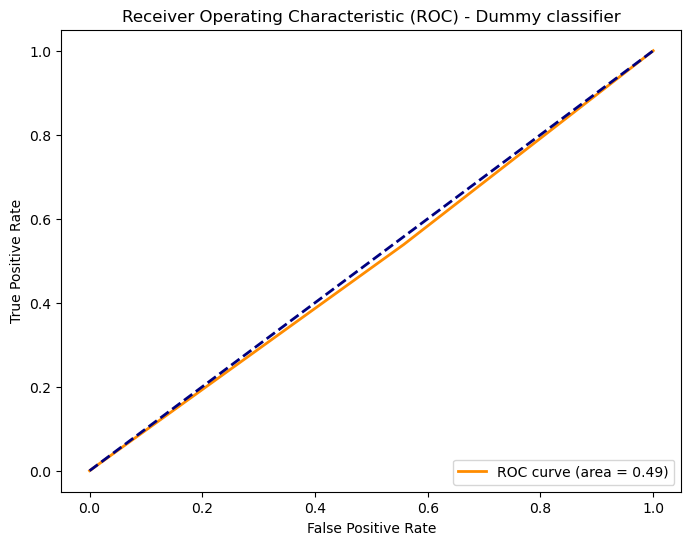

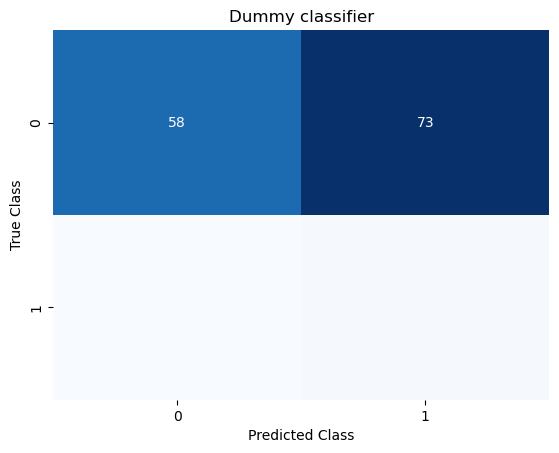

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.09      0.54      0.15        13

    accuracy                           0.45       144
   macro avg       0.50      0.49      0.37       144
weighted avg       0.83      0.45      0.55       144



In [458]:
# Create dummy classifier
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(features_train, target_train)

# Predict on test features
dummy_prediction = dummy.predict(features_test)

# Visualize the ROC curve
myPlotROCcurve(target_test, dummy_prediction, "Dummy classifier")

# Visualize the confusion matrix
myPlotConfusionMatrix(target_test, dummy_prediction, "Dummy classifier")

dummy_report = classification_report(target_test, dummy_prediction, output_dict=True)
print(classification_report(target_test, dummy_prediction))

dummy_bs_report_fromalized = myResultFormalizer(dummy_report, "Dummy classifier")

results_list.append(dummy_bs_report_fromalized)


### RandomForestClassifier, Basic split

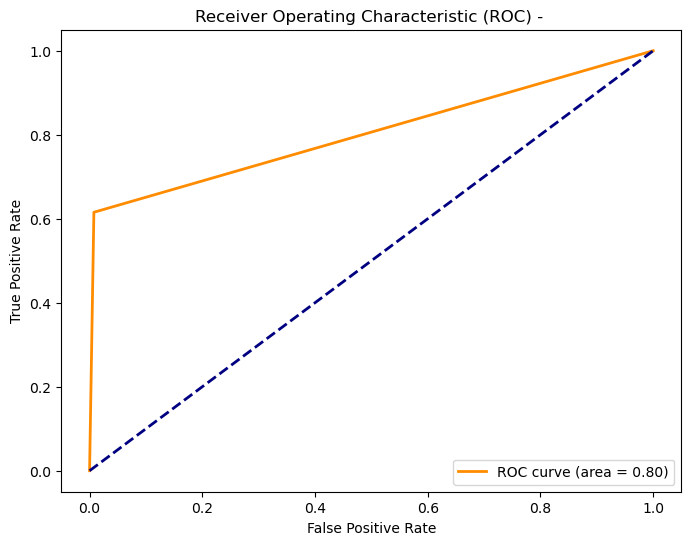

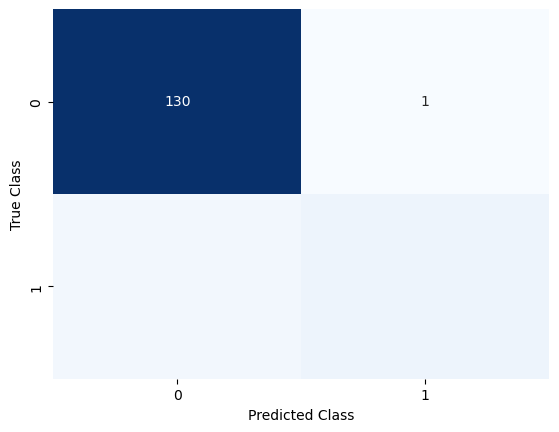


Basic split Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       131
           1       0.89      0.62      0.73        13

    accuracy                           0.96       144
   macro avg       0.93      0.80      0.85       144
weighted avg       0.96      0.96      0.95       144



In [459]:
# Create classifier
rf_classifier = RandomForestClassifier()

model_title = "Random Forest Classifier, Basic split"

# Train model
rf_classifier.fit(features_train, target_train)

# Predict on test features
rfc_prediction = rf_classifier.predict(features_test)

# Visualize the ROC curve
myPlotROCcurve(target_test, rfc_prediction)

# Visualize the confusion matrix
myPlotConfusionMatrix(target_test, rfc_prediction)

# Print classification report
print("\nBasic split Random Forest Classifier Classification Report:")
rfc_report = classification_report(target_test, rfc_prediction, output_dict=True)
print(classification_report(target_test, rfc_prediction))

rfc_bs_report_formalized = myResultFormalizer(rfc_report, model_title)

results_list.append(rfc_bs_report_formalized)


### RandomForestClassifier, Cross-Validation

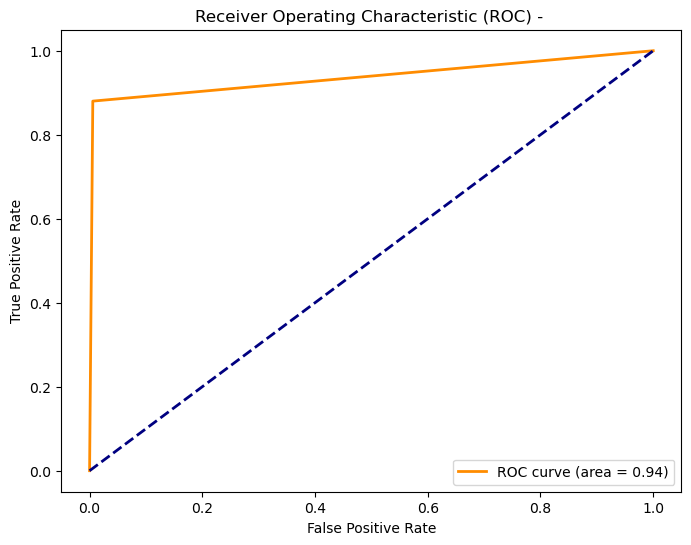

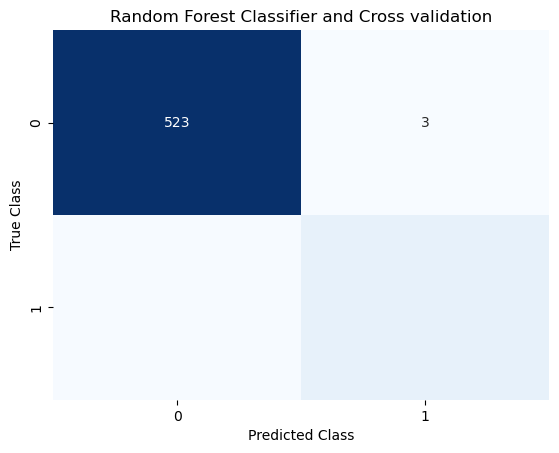

In [460]:
# Create Random Forest Classifier object
rf_classifier = RandomForestClassifier()

model_title = "Random Forest Classifier and Cross validation"

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

rf_cv_results, predictions = myCrossValidation(rf_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions)

myPlotConfusionMatrix(target, predictions, model_title)

rf_cv_results.head()

results_list.append(rf_cv_results)
results_list_cv_only.append(rf_cv_results)


### Naive Bayes, Basic split

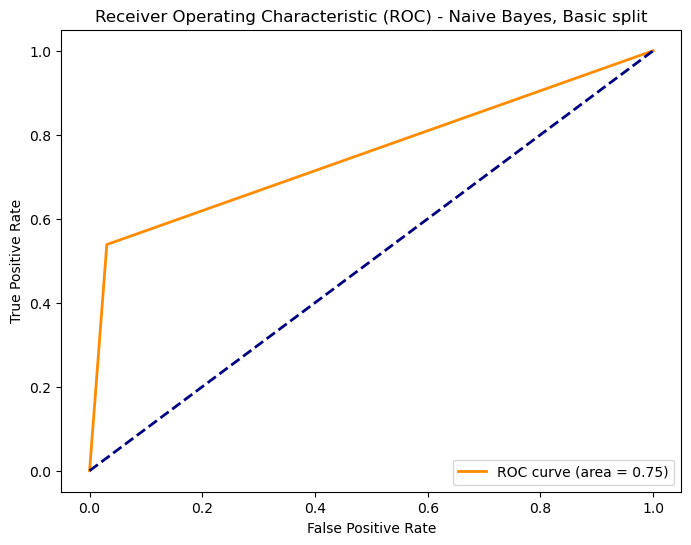

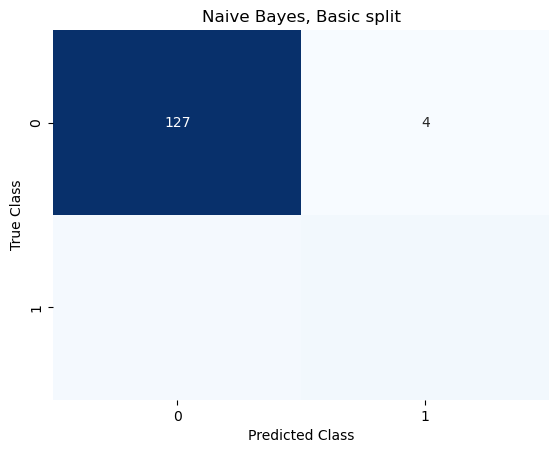


Basic split Naive Bayes Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       131
           1       0.64      0.54      0.58        13

    accuracy                           0.93       144
   macro avg       0.80      0.75      0.77       144
weighted avg       0.93      0.93      0.93       144



In [461]:
# Create Naive Bayes Classifier object
nb_classifier = GaussianNB()

model_title = "Naive Bayes, Basic split"

# Train model
nb_classifier.fit(features_train, target_train)

# Predict on test features
nb_prediction = nb_classifier.predict(features_test)

# Visualize the ROC curve
myPlotROCcurve(target_test, nb_prediction, model_title)

# Visualize the confusion matrix
myPlotConfusionMatrix(target_test, nb_prediction, model_title)

# Print classification report
print("\nBasic split Naive Bayes Classifier Classification Report:")
nb_report = classification_report(target_test, nb_prediction, output_dict=True)
print(classification_report(target_test, nb_prediction))

nb_bs_report_formalized = myResultFormalizer(nb_report, model_title)

results_list.append(nb_bs_report_formalized)


### Naive Bayes, Cross-Validation

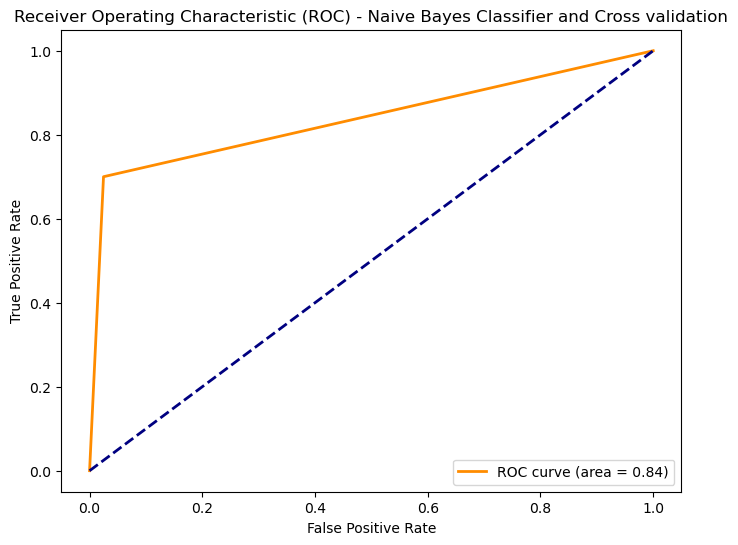

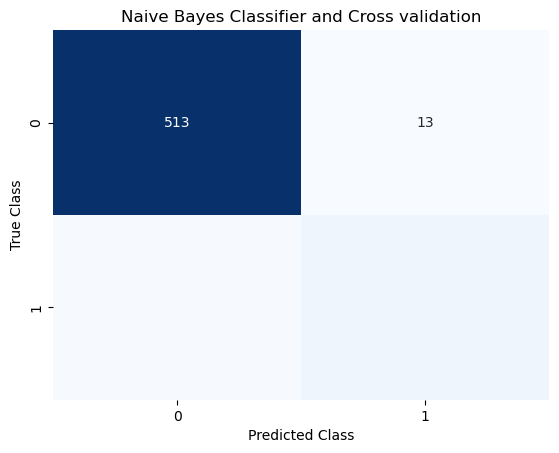

In [462]:
# Create Naive Bayes Classifier object
nb_classifier = GaussianNB()

model_title = "Naive Bayes Classifier and Cross validation"

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

nb_cv_results, predictions = myCrossValidation(nb_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

nb_cv_results.head()

results_list.append(nb_cv_results)
results_list_cv_only.append(nb_cv_results)

### K-Nearest Neighbors, Basic split

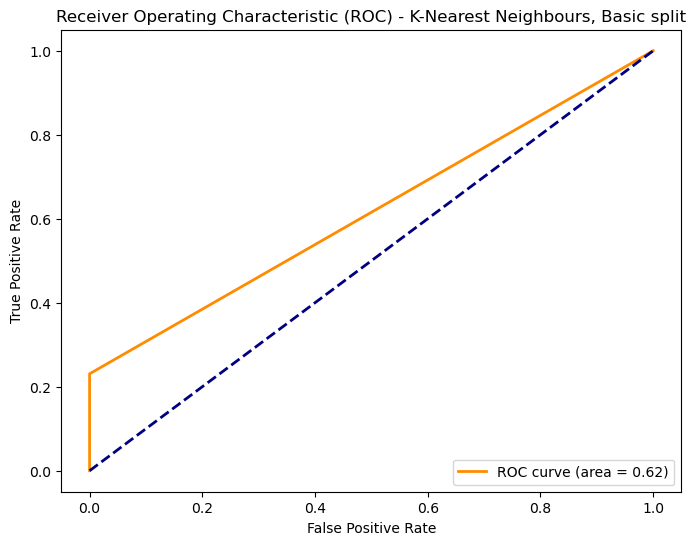

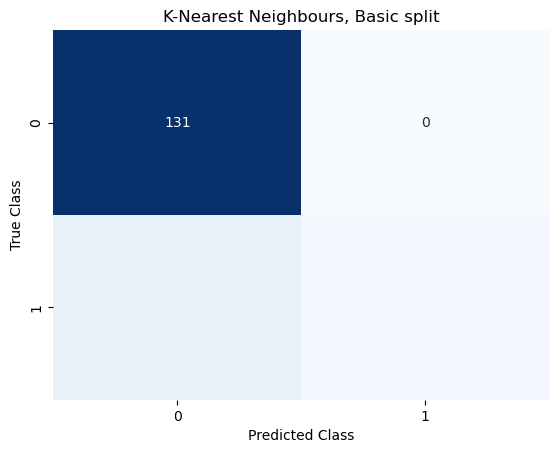


Basic split K-Nearest Neighbours Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       131
           1       1.00      0.23      0.38        13

    accuracy                           0.93       144
   macro avg       0.96      0.62      0.67       144
weighted avg       0.94      0.93      0.91       144



In [463]:
# Create K-Nearest Neighbors classifier object
knn_classifier = KNeighborsClassifier()

model_title = "K-Nearest Neighbours, Basic split"

# Train model
knn_classifier.fit(features_train, target_train)

# Predict on test features
knn_prediction = knn_classifier.predict(features_test)

# Visualize the ROC curve
myPlotROCcurve(target_test, knn_prediction, model_title)

# Visualize the confusion matrix
myPlotConfusionMatrix(target_test, knn_prediction, model_title)

# Print classification report
print("\nBasic split K-Nearest Neighbours Classifier Classification Report:")
knn_bs_report = classification_report(target_test, knn_prediction, output_dict=True)
print(classification_report(target_test, knn_prediction))

knn_bs_report_formalized = myResultFormalizer(knn_bs_report, model_title)

results_list.append(knn_bs_report_formalized)

### K-Nearest Neighbors, Cross-Validation

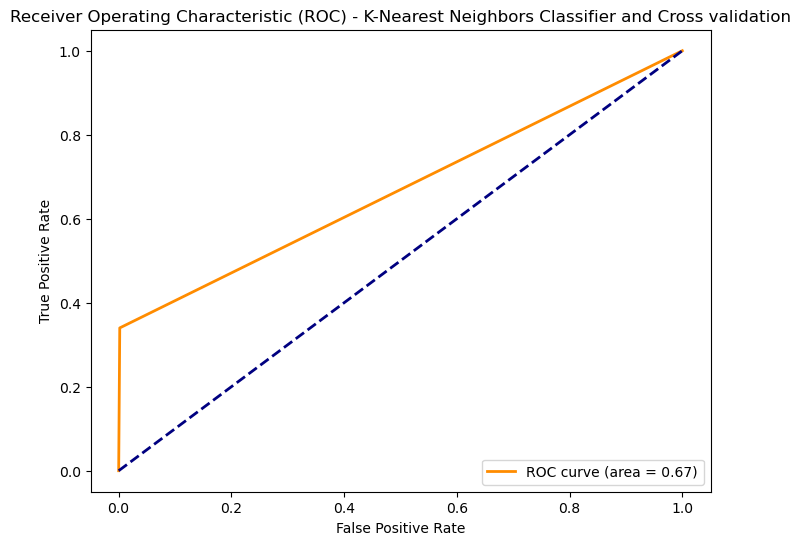

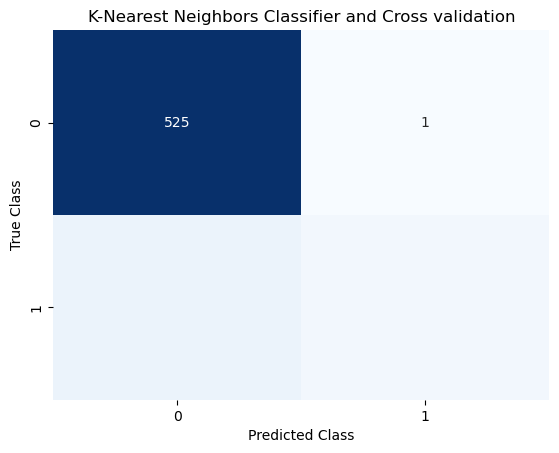

In [464]:
# Create K-Nearest Neighbors Classifier object
knn_classifier = KNeighborsClassifier()

model_title = "K-Nearest Neighbors Classifier and Cross validation"

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

knn_cv_results, predictions = myCrossValidation(knn_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

knn_cv_results.head()

results_list.append(knn_cv_results)
results_list_cv_only.append(knn_cv_results)

### Gradient Boosting, Basic split

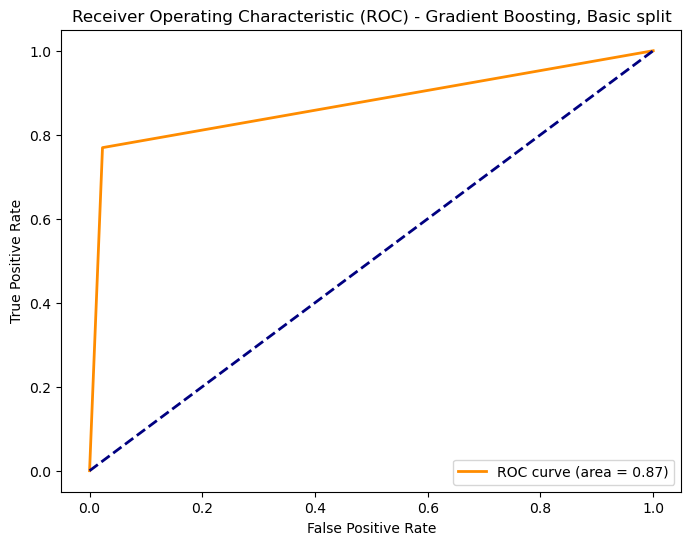

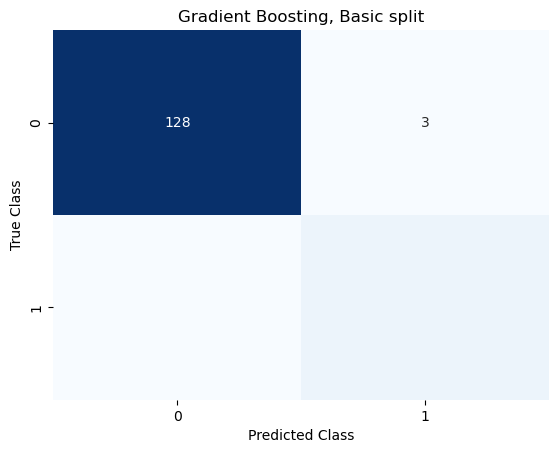


Basic split Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       131
           1       0.77      0.77      0.77        13

    accuracy                           0.96       144
   macro avg       0.87      0.87      0.87       144
weighted avg       0.96      0.96      0.96       144



In [465]:
# Create Gradient Boosting classifier object
gb_classifier = GradientBoostingClassifier()

model_title = "Gradient Boosting, Basic split"

# Train model
gb_classifier.fit(features_train, target_train)

# Predict on test features
gb_prediction = gb_classifier.predict(features_test)

# Visualize the ROC curve
myPlotROCcurve(target_test, gb_prediction, model_title)

# Visualize the confusion matrix
myPlotConfusionMatrix(target_test, gb_prediction, model_title)

# Print classification report
print("\nBasic split Gradient Boosting Classifier Classification Report:")
gb_bs_report = classification_report(target_test, gb_prediction, output_dict=True)
print(classification_report(target_test, gb_prediction))

gb_bs_report_formalized = myResultFormalizer(gb_bs_report, model_title)

results_list.append(gb_bs_report_formalized)

### Gradient Boosting, Cross-Validation

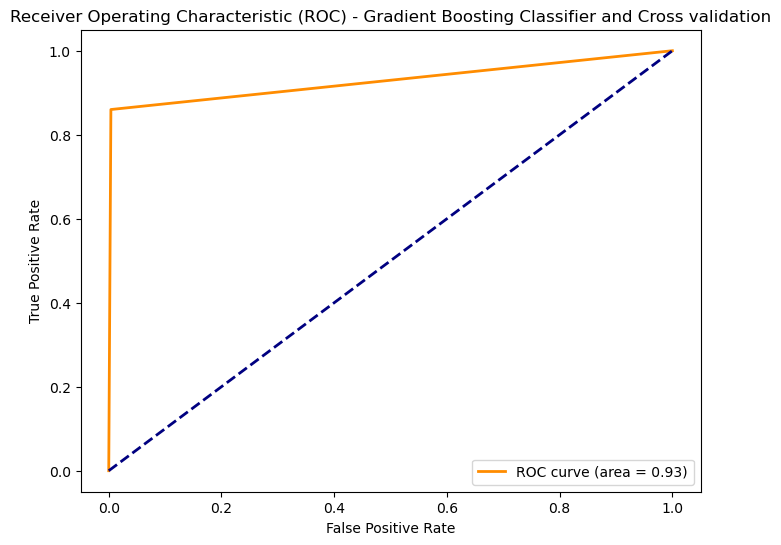

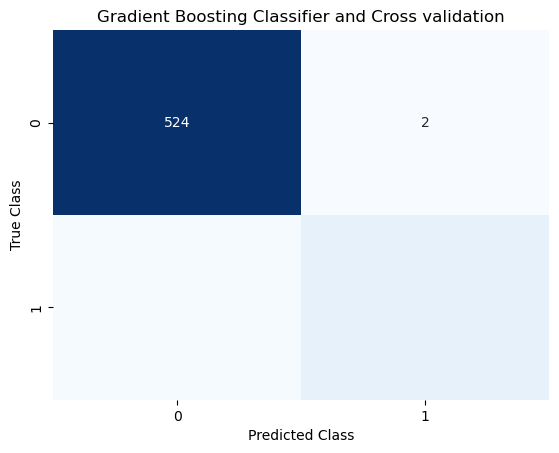

In [466]:
# Create Gradient Boosting Classifier object
gb_classifier = GradientBoostingClassifier()

model_title = "Gradient Boosting Classifier and Cross validation"

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

gb_cv_results, predictions = myCrossValidation(gb_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

gb_cv_results.head()

results_list.append(gb_cv_results)
results_list_cv_only.append(gb_cv_results)

### Logistic Regression, Basic split

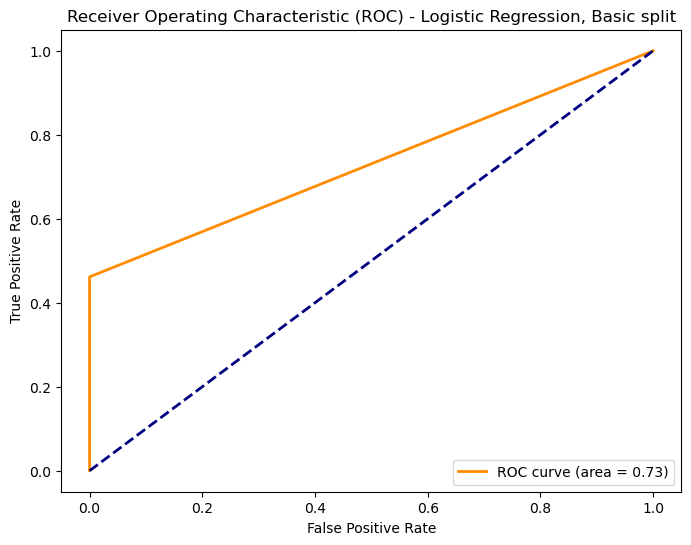

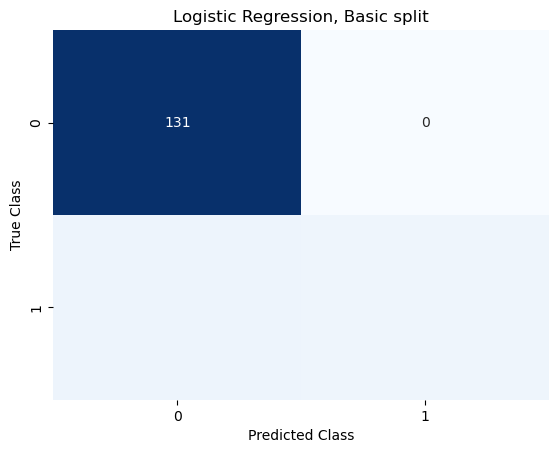


Basic split Logistic Regression Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       131
           1       1.00      0.46      0.63        13

    accuracy                           0.95       144
   macro avg       0.97      0.73      0.80       144
weighted avg       0.95      0.95      0.94       144



In [467]:
# Create Logistic Regression classifier object
lr_classifier = LogisticRegression()

model_title = "Logistic Regression, Basic split"

# Train model
lr_classifier.fit(features_train, target_train)

# Predict on test features
lr_prediction = lr_classifier.predict(features_test)

# Visualize the ROC curve
myPlotROCcurve(target_test, lr_prediction, model_title)

# Visualize the confusion matrix
myPlotConfusionMatrix(target_test, lr_prediction, model_title)

# Print classification report
print("\nBasic split Logistic Regression Classifier Classification Report:")
lr_bs_report = classification_report(target_test, lr_prediction, output_dict=True)
print(classification_report(target_test, lr_prediction))

gb_bs_report_formalized = myResultFormalizer(lr_bs_report, model_title)

results_list.append(gb_bs_report_formalized)

### Logistic Regression, Cross-Validation

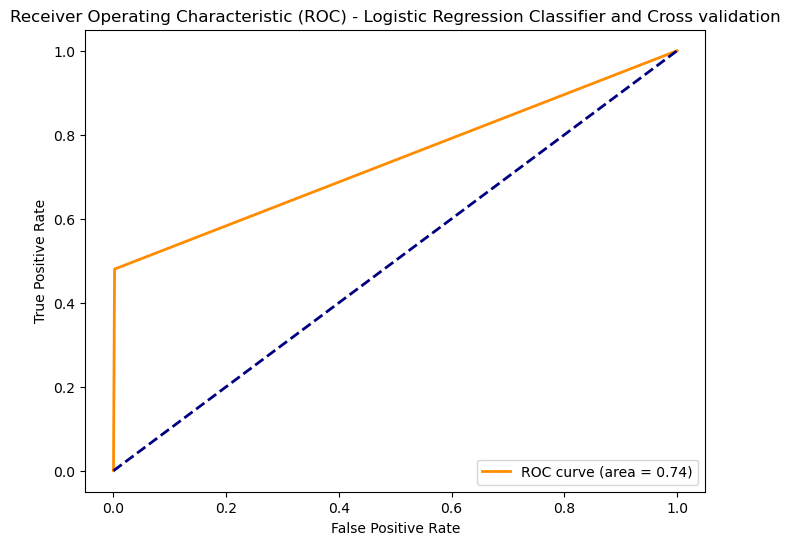

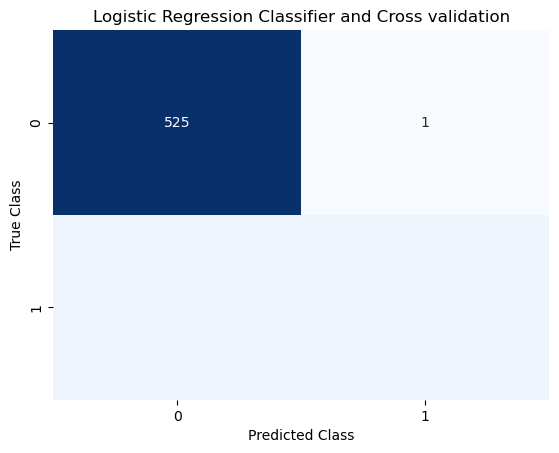

In [468]:
# Create Logistic Regression classifier object
lr_classifier_cv = LogisticRegression()

model_title = "Logistic Regression Classifier and Cross validation"

lr_cv_results, predictions = myCrossValidation(lr_classifier_cv, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

lr_cv_results.head()

results_list.append(lr_cv_results)
results_list_cv_only.append(lr_cv_results)

## Results compared

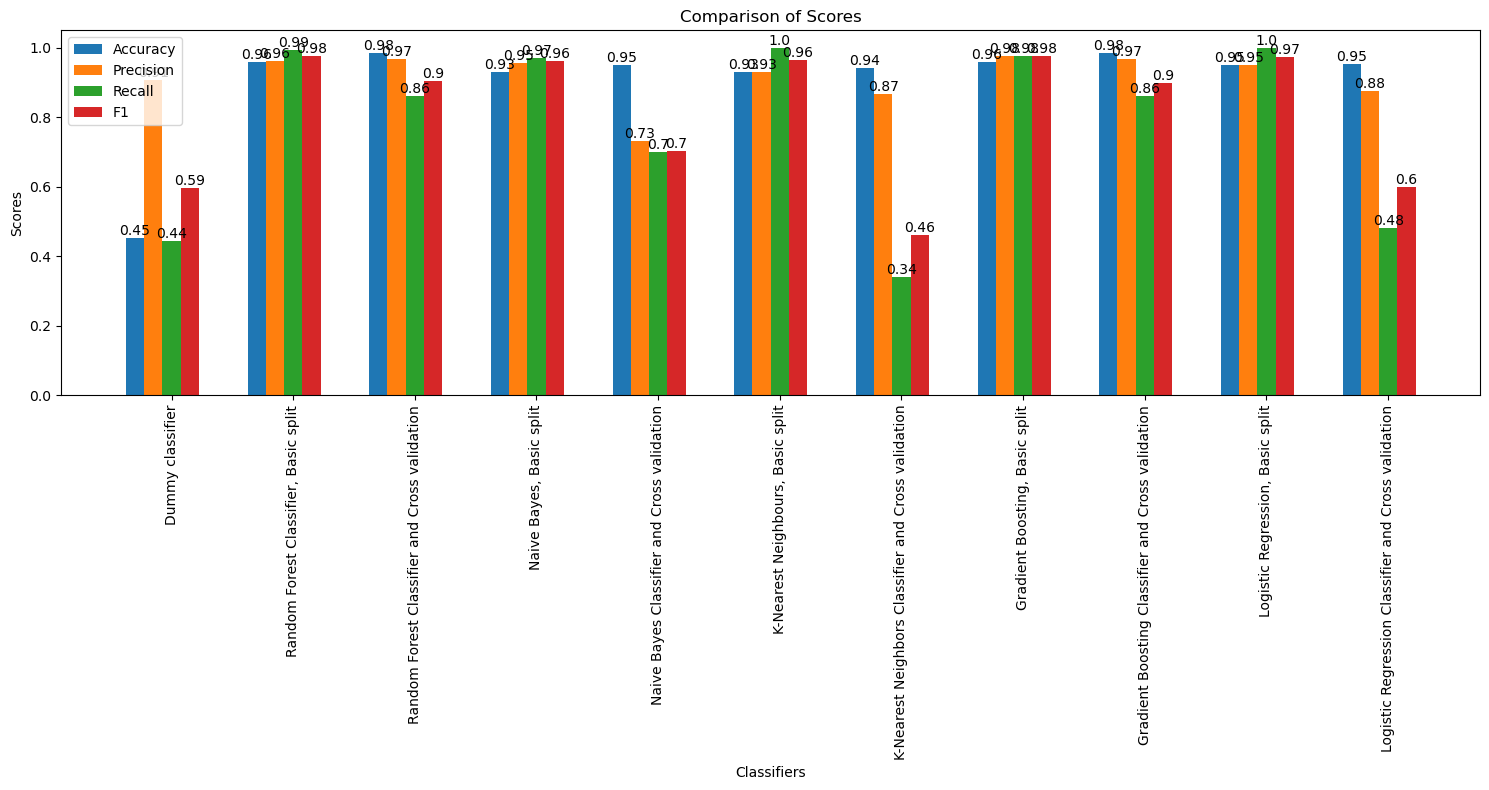

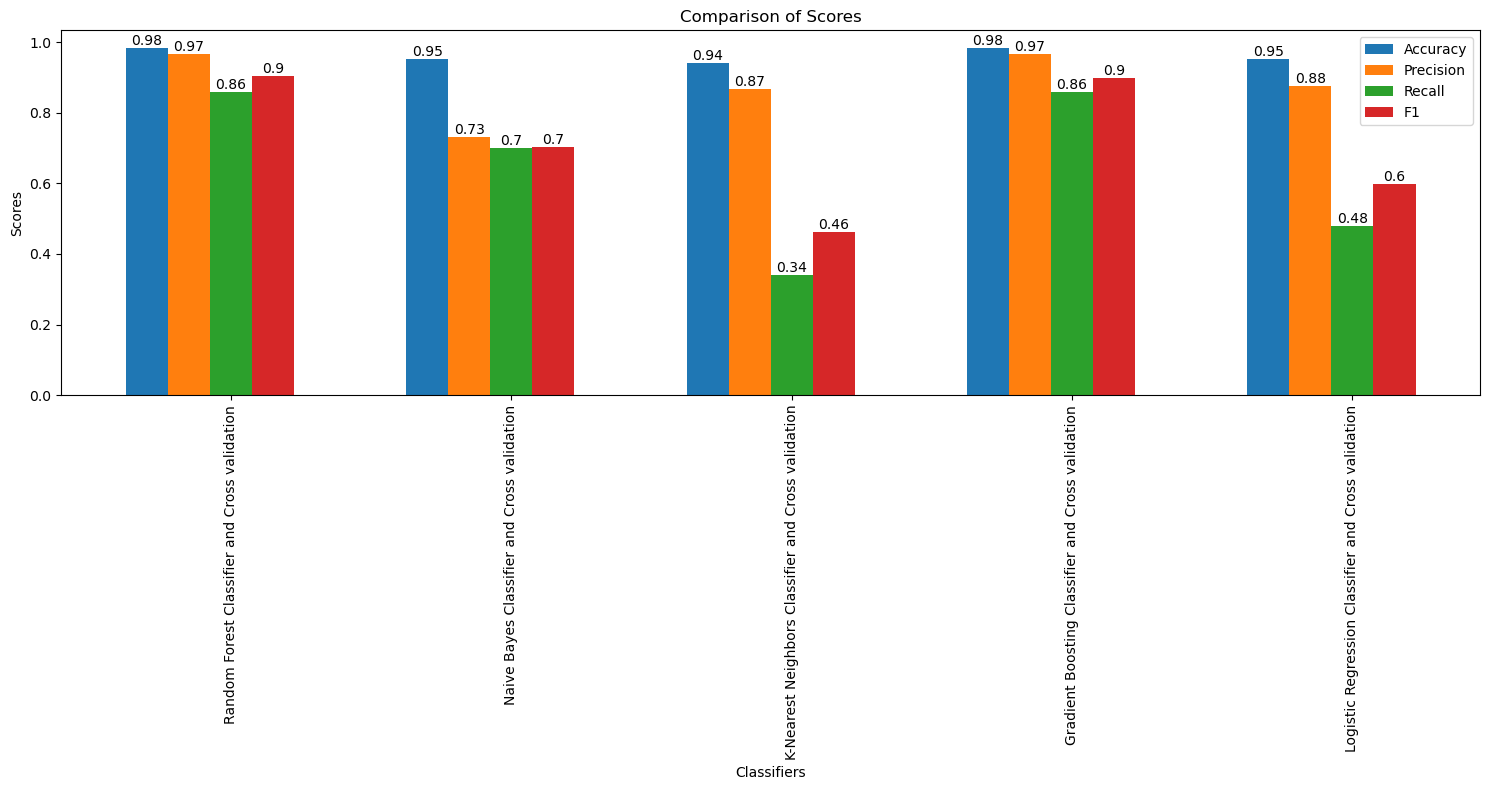

In [469]:
def plot_classifier_scores(dataframes, metrics, angle = 90):
    # Plotting
    bar_width = 0.15
    index = np.arange(len(dataframes))

    fig, ax = plt.subplots(figsize=(15, 8))

    for i, metric in enumerate(metrics):
        scores = [df[metric].iloc[0] for df in dataframes]
        bars = ax.bar(index + (i - len(metrics) / 2) * bar_width, scores, bar_width, label=metric)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, round(height, 2), ha='center', va='bottom')

    ax.set_xlabel('Classifiers')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Scores')
    ax.set_xticks(index)
    ax.set_xticklabels([df['Model'].iloc[0] for df in dataframes], rotation=angle)
    ax.legend()

    plt.tight_layout()
    plt.show()



# List of feature names
feature_names = ["Accuracy", "Precision", "Recall", "F1"]


plot_classifier_scores(results_list, feature_names)

plot_classifier_scores(results_list_cv_only, feature_names)



## Hiperparameters tuning

Nećemo razmatrati rezultate dobijene klasičnom podelom na train i test skupove zato što je dataset jako nebalansiran i rezultati koji su dobijeni nisu od relevantne koristi.

Za dalje podešavanje hiperparametara nastavljamo sa Random Forest i Gradient Boosting klasifikatorima zato što su dali najbolje rezultate.

### Random Forest Hiperparameters tuning

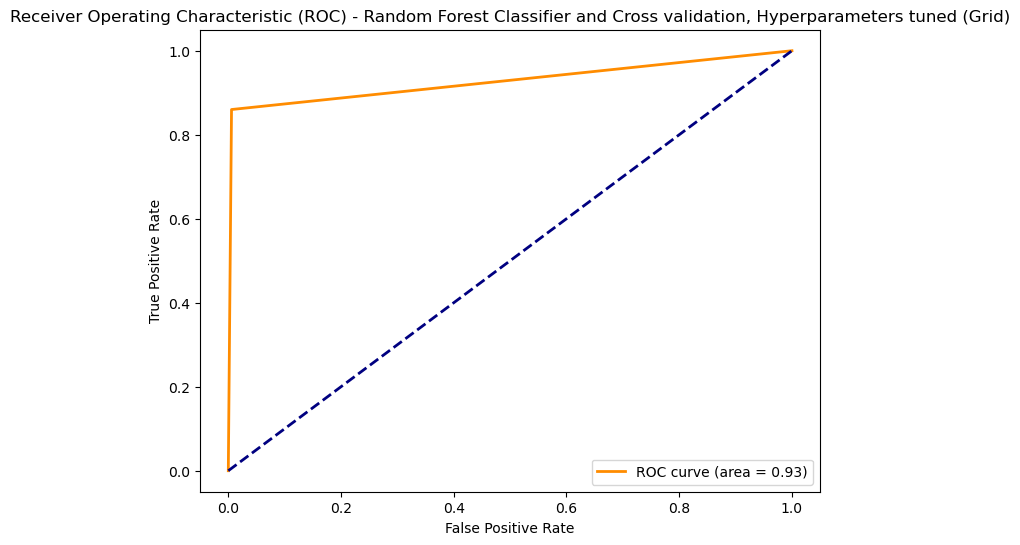

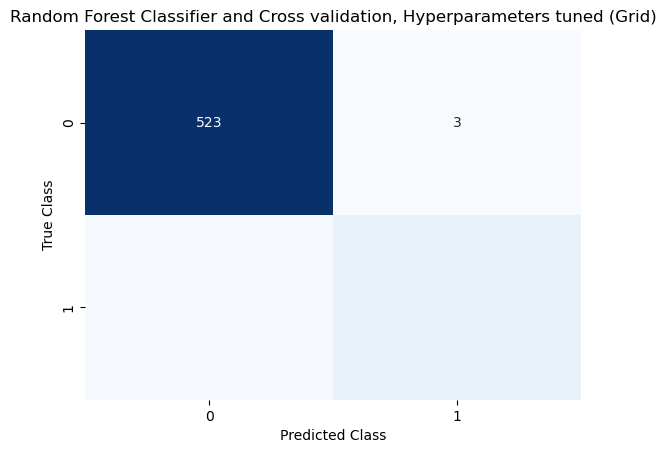

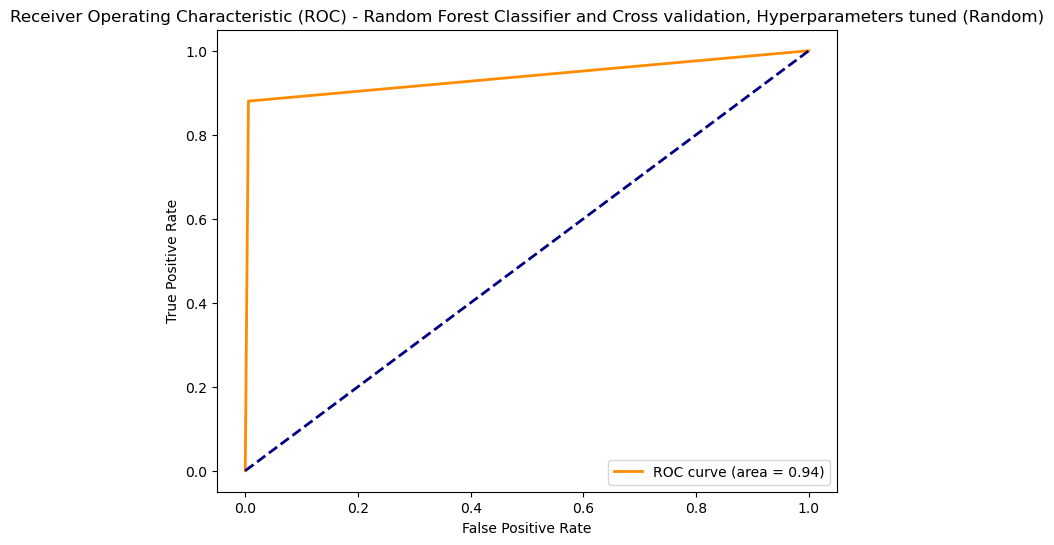

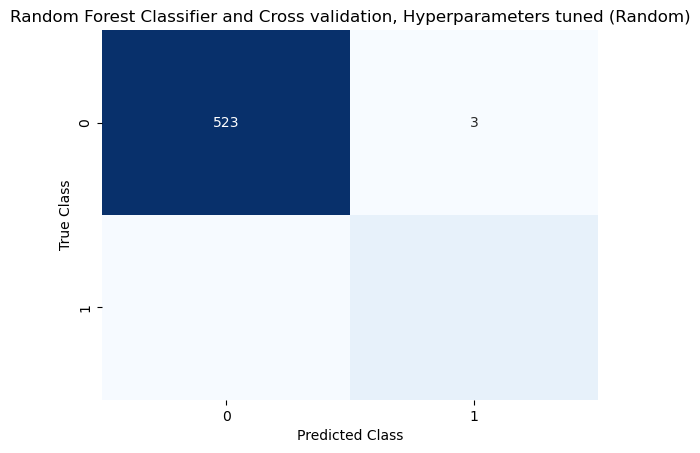

In [473]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Create a Random Forest classifier object
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Perform randoized search
np.random.seed(42)
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, cv=5, n_jobs=-1)
random_search.fit(features, target)

rand_params = random_search.best_params_

## Perform grid search
#grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
#grid_search.fit(features, target)
## Best hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50

## Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best hyperparameters:", best_params)

best_params = {'bootstrap': True, 
               'max_depth': 20, 
               'max_features': 'log2', 
               'min_samples_leaf': 1, 
               'min_samples_split': 5, 
               'n_estimators': 50}

best_params_classifier = RandomForestClassifier(**best_params)

model_title = "Random Forest Classifier and Cross validation, Hyperparameters tuned (Grid)"

rf_cv_hp_grid_results, predictions = myCrossValidation(best_params_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

rf_cv_hp_grid_results.head()


rnd_params_classifier = RandomForestClassifier(**rand_params)

model_title = "Random Forest Classifier and Cross validation, Hyperparameters tuned (Random)"

rf_cv_hp_rnd_results, predictions = myCrossValidation(rnd_params_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

rf_cv_hp_rnd_results.head()


final_results = list()
final_results.append(rf_cv_hp_grid_results)
final_results.append(rf_cv_hp_rnd_results)


### Gradient Boosting Hiperparameters tuning

c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=

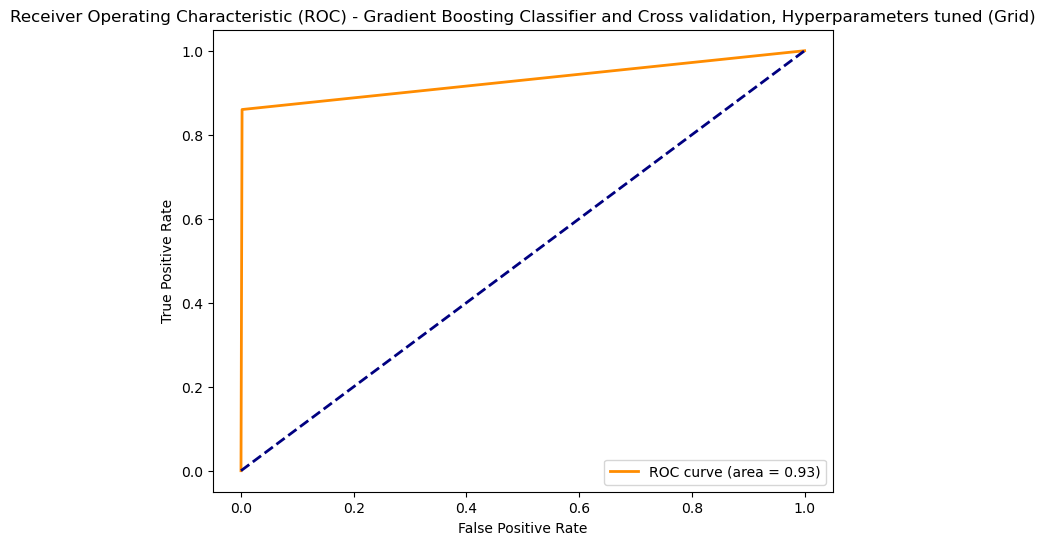

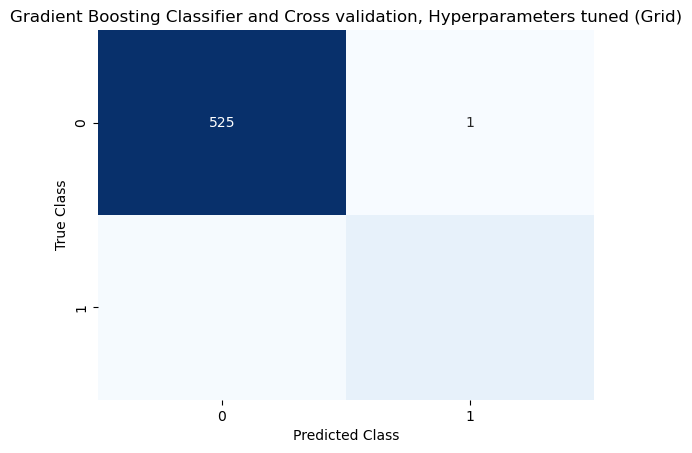

c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Nemanja\.conda\envs\mlenv\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=

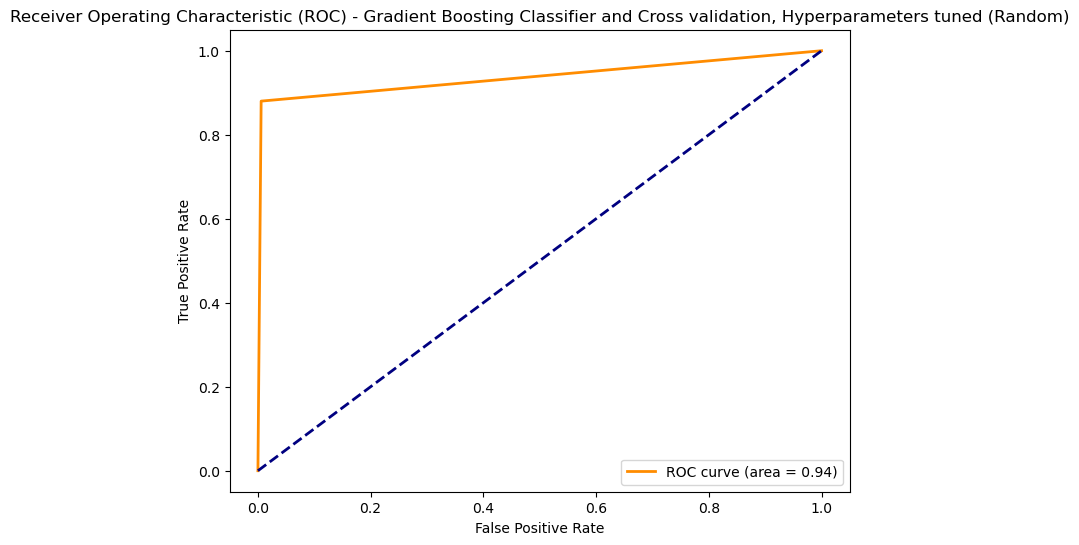

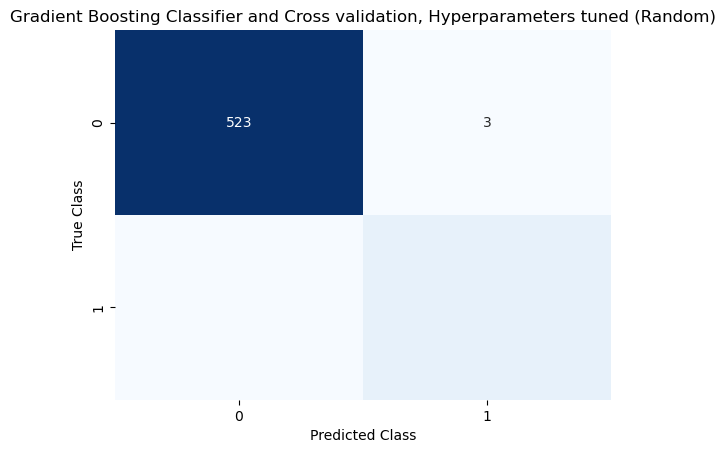

In [474]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Create a Random Forest classifier object
gb_classifier = GradientBoostingClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform randoized search
np.random.seed(42)
random_search = RandomizedSearchCV(estimator=gb_classifier, param_distributions=param_grid, cv=5, n_jobs=-1)
random_search.fit(features, target)

rand_params = random_search.best_params_

## Perform grid search
#grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
#grid_search.fit(features, target)
## Best hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50

## Get the best hyperparameters
#best_params = grid_search.best_params_
#print("Best hyperparameters:", best_params)

best_params = { 'learning_rate': 0.5, 
                'max_depth': 7, 
                'max_features': 'sqrt', 
                'min_samples_leaf': 2, 
                'min_samples_split': 10,
                  'n_estimators': 50}

best_params_classifier = GradientBoostingClassifier(**best_params)

model_title = "Gradient Boosting Classifier and Cross validation, Hyperparameters tuned (Grid)"

gb_cv_hp_grid_results, predictions = myCrossValidation(best_params_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

gb_cv_hp_grid_results.head()


rnd_params_classifier = GradientBoostingClassifier(**rand_params)

model_title = "Gradient Boosting Classifier and Cross validation, Hyperparameters tuned (Random)"

gb_cv_hp_rnd_results, predictions = myCrossValidation(rnd_params_classifier, skf, features, target, model_title)

myPlotROCcurve(target, predictions, model_title)

myPlotConfusionMatrix(target, predictions, model_title)

gb_cv_hp_rnd_results.head()



final_results.append(gb_cv_hp_grid_results)
final_results.append(gb_cv_hp_rnd_results)


#### Comparison

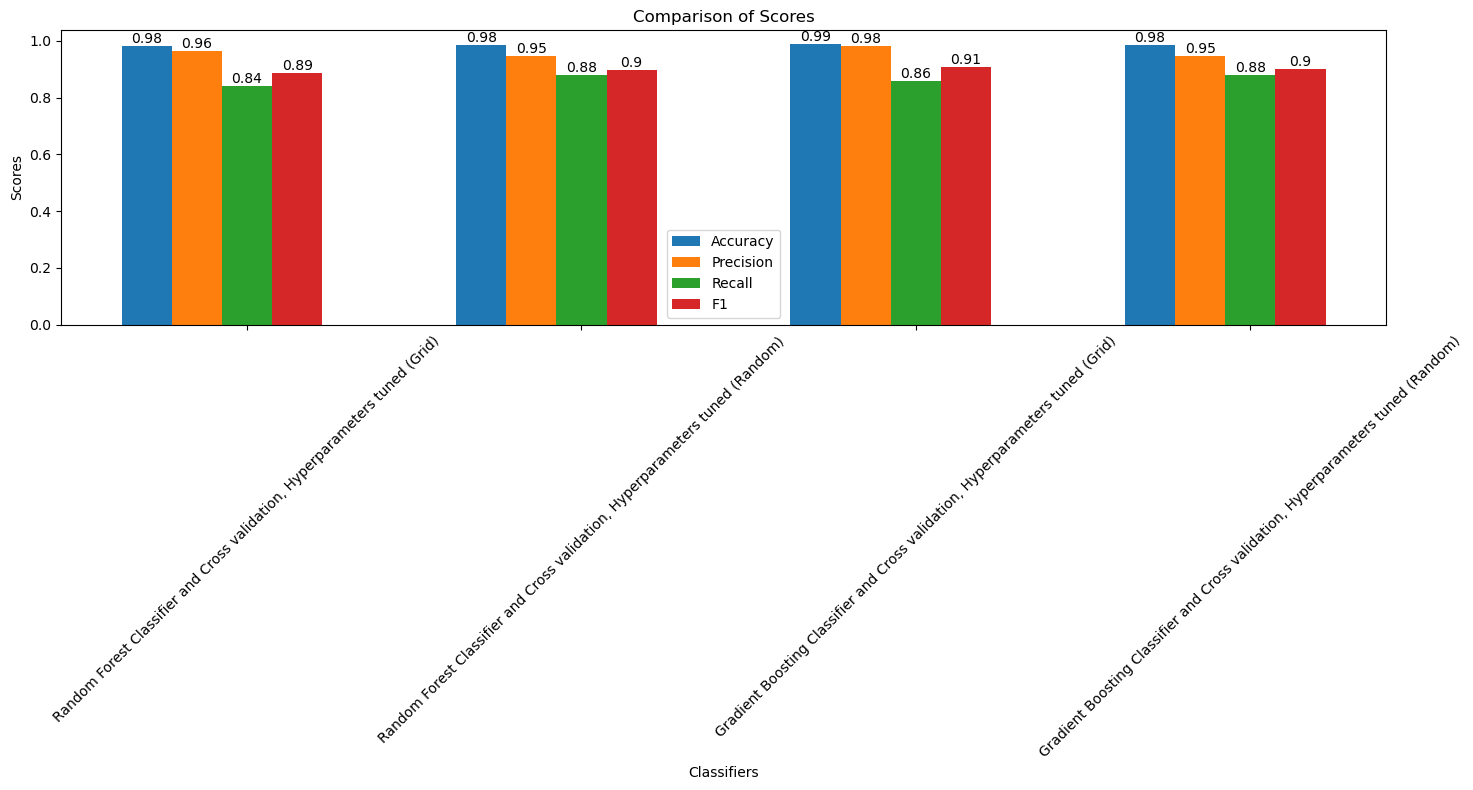

In [475]:
plot_classifier_scores(final_results, feature_names, angle = 45)

Zaključujemo da je najbolje rezultate dao Gradient Boosting algoritam sa isprobavanjem svih varijacija parametara, dok je random biranje parametara dalo slične rezultate za oba algoritma.